# Model Training and Evaluation

---

## Problem Statement

> Test performance of students may depend on multiple factors and not merely on how the student prepared for it.\
> Goal of this project is to understand how various factors including student's **gender**, **ethnicity**, **parental level of education** etc impacts his/her test performance.
---

# Objectives

1. Perform **Feature Engineering** and **Data processing**
   - Create a single continuous target variable for prediction
2. **Data Transformation** for machine learning data ingestion
   - **Scaling** the numeric features
   - **One-hot encoding** the categorical features
3. **Feature Selection** by checking for **multicolinearity** in input features
4. Train multiple **machine learning algorithms** for **regression** task
5. **Model Evaluation** to select final model for addressing the problem statement
6. **Hyperparameter tuning** to optimize the model

**Models** to be trained $\rightarrow$
1. Linear Regression, Ridge Regression (L2 Regularization), Lasso Regression (L1 Regularization)
2. Decision Tree, Random Forest
3. XGBoost, Catboost, Adaboost
4. Support Vector Machine

From **previous Exploratory Data Analysis** following were observed $\rightarrow$
1. There are **no missing values** in the dataset
2. There are **no duplicate entries** in the dataset
3. Following are the data types:
    - **Numeric columns**: `math_score`, `reading_score`, `writing_score`
    - **Categorical columns**: `gender`, `race_ethnicity`, `parental_level_of_education`, `lunch`, `test_preparation_course`
4. `parental_level_of_education` has 6 unique categories, but 2 of them indicate similar level of education $\rightarrow$ 'high school' and 'some high school'
5. `test_preparation_course` has an unique value 'none' which may indicate that the student did not have any test preparation materials

---

## Data Collection

---

### Dataset Source
[Students Performance in Exams, Kaggle](https://www.kaggle.com/datasets/spscientist/students-performance-in-exams?datasetId=74977)

### About the Dataset
1. Includes marks secured by high school students in the United States of America (USA)

|Feature/Column|Explanation|
|:---:|:---:|
|`gender`|Biological sex of student (Male/Female)|
|`race_ethnicity`|Ethnicity of student (anonymized) $\rightarrow$ Group A/B/C/D/E|
|`parental_level_of_education`|Highest qualification of parents $\rightarrow$ Bachelor's degree/Some college/Master's degree/Associate's degree/High school|
|`lunch`|Type of lunch eaten by student before taking the test $\rightarrow$ Standard or Free/reduced|
|`test_preparation_course`|Whether student completed the test preparation materials before taking the test|
|`math_score`||
|`reading_score`||
|`writing_score`||

---

### Importing Data and Required Libraries

In [53]:
# DEPENDENCIES

# Basic Imports

# for numerical computations
import numpy as np
# for working with dataframes and `csv` files
import pandas as pd
# for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
# for suppressing warnings
import warnings
warnings.filterwarnings("ignore")
# for working with file paths
from pathlib import Path

# Machine Learning specific imports

# for data processing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# for dataset creation
from sklearn.model_selection import train_test_split

# for model building
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
# for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
# for linear regression model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [54]:
# DATA

file_path = Path("data/stud.csv")

# load csv into dataframe
dataset = pd.read_csv(file_path)

# check if dataset loaded
dataset.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [55]:
# make copy of dataframe to avoid accidental changes
df = dataset.copy()

## Feature Engineering

> Currently dataset has **three continuous features**: `math_score`, `reading_score`, `writing_score`.\
> These three will be combined into a **single metric** `avg_score` indicating the average marks scored by a student in the three tests.\
> This will then be used as the **target variable** for the **regression model** to predict.
---

In [56]:
# create new feature `avg_score`
df["avg_score"] = (df["math_score"] + df["writing_score"] + df["reading_score"])/3 ## Average score in 3 tests

df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,avg_score
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


## Data Transformation

---

### Preparing `X` (Input features) and `y` (Target variable)

In [57]:
# separate out column names

categorical_cols = [
    col for col in df.columns
    if df[col].dtype == "O"
]

numeric_cols = [
    col for col in df.columns
    if df[col].dtype != "O"
]

print(f"Categorical columns -> {categorical_cols}\n\nNumeric columns -> {numeric_cols}")

Categorical columns -> ['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course']

Numeric columns -> ['math_score', 'reading_score', 'writing_score', 'avg_score']


In [71]:
# input features
X = df.drop(columns=["avg_score"])
# target variable
y = df["avg_score"]

In [72]:
# check input features dataframe
X.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [73]:
# check target variable vector
y.head()

0    72.666667
1    82.333333
2    92.666667
3    49.333333
4    76.333333
Name: avg_score, dtype: float64

In [77]:
# numerical features column names
numerical_features = X.select_dtypes(include="number").columns

# categorical features column names
categorical_features = X.select_dtypes(include="object").columns

### Data Processing Pipeline

In [86]:
# initialize requirements for creating column transformer pipeline

# for scaling numerical features
numerical_transformer = StandardScaler()
# for one-hot encoding categorical features
categorical_transformer = OneHotEncoder()

# data processing pipeline
data_processing_pipeline = ColumnTransformer([
    ("OneHotEncoder", categorical_transformer, categorical_features), ## ("name of procedure", transformer, data to transform)
    ("StandardScaler", numerical_transformer, numerical_features)
])

### Data Transformation

In [87]:
# transform the input features by passing it through data processing pipeline
X_transformed = data_processing_pipeline.fit_transform(X)

In [88]:
# create a separate dataframe for checking multicolinearity
X_multicolinearity_check = pd.DataFrame(data_processing_pipeline.fit_transform(X),
                                       columns=data_processing_pipeline.get_feature_names_out())

In [80]:
# check input features after transformation

print(f"BEFORE DATA PROCESSING ->\n{X.shape[0]} samples and {X.shape[1]} features.\n\n")
print(f"AFTER DATA PROCESSING ->\n{X_transformed.shape[0]} samples and {X_transformed.shape[1]} features.")

BEFORE DATA PROCESSING ->
1000 samples and 8 features.


AFTER DATA PROCESSING ->
1000 samples and 20 features.


---

### Check for Multicolinearity and perform Feature Selection

In [90]:
# check for multicolinearity
multicolinearity = X_multicolinearity_check.corr()

In [92]:
def features_to_drop(dataset, threshold):
    """
    INPUT ->
    `dataset`: Pandas dataframe containing input features only
    `threshold`: Minimum threshold for pearson correlation coefficient
                between 2 input features.
                Features which have correlation > threshold will be returned.
    
    OUTPUT ->
    `cols_to_drop`: set of feature names which is to be dropped
                    to avoid multicolinearity.
    """
    # empty set to store names of columns to drop
    cols_to_drop = set()
    # correlation matrix
    correlation_matrix = dataset.corr()
    # column names (input features)
    col_names = correlation_matrix.columns
    
    # iterate through lower triangular (except diagonal) matrix
    # of the correlation matrix
    # NOTE: Correlation matrix is symmetric. Hence only checking lower triangle portion
    # will ensure all possible pairs of input features are considered.
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            # check correlation (pearson correlation)
            r = abs(correlation_matrix.iloc[i, j])
            # threshold check
            if r > threshold:
                cols_to_drop.add(col_names[i])
    
    # return set of column names (input features) to drop
    return cols_to_drop

In [93]:
cols_to_drop = features_to_drop(X_multicolinearity_check, threshold=0.85)

cols_to_drop

{'OneHotEncoder__gender_male',
 'OneHotEncoder__lunch_standard',
 'OneHotEncoder__test_preparation_course_none',
 'StandardScaler__writing_score'}

In [94]:
# drop similar columns
X_transformed_dropped = X_multicolinearity_check.drop(columns=cols_to_drop)

In [96]:
# check input features after dropping similar columns 
print(f"AFTER DROPPING COLUMNS ->\n{X_transformed_dropped.shape[0]} samples and {X_transformed_dropped.shape[1]} features.")

AFTER DROPPING COLUMNS ->
1000 samples and 16 features.


### Create Training set and Test set

In [98]:
# split dataset into training set (80% samples) and test set (20% samples)

# test set size
test_size = 0.2 ## 20% samples

X_train, X_test, y_train, y_test = train_test_split(X_transformed_dropped, y,
                                                    test_size=test_size, random_state=0)

print(f"TRAINING SET -> {X_train.shape[0]} samples and {X_train.shape[1]} features.\n")
print(f"TEST SET -> {X_test.shape[0]} samples and {X_test.shape[1]} features.")

TRAINING SET -> 800 samples and 16 features.

TEST SET -> 200 samples and 16 features.


---

## Helper Functions
Following functions will be created for convenience $\rightarrow$
1. `evaluate_model`: to return score of model performance on various metrics

---

In [99]:
def evaluate_model(true_values, predicted_values):
    """
    Evaluates a regression machine learning model's
    performance on following metrics ->
        1. Mean Absolute Error (MAE)
        2. Root Mean Squared Error (RMSE)
        3. R^2 Score (Coefficient of Determination)
    
    Input Parameters ->
        true_values: Array of ground truth values (target variable)
        predicted_values: Array of model's predictions of target variable
    
    Returns: Above scores as a 3-tuple in that order
    
    """
    # mae
    mae = mean_absolute_error(y_true=true_values, y_pred=predicted_values)
    # mse
    mse = mean_squared_error(y_true=true_values, y_pred=predicted_values)
    # rmse
    rmse = np.sqrt(mse)
    # r2
    r2 = r2_score(y_true=true_values, y_pred=predicted_values)
    
    return (mae, rmse, r2)

## Model Training

---

In [100]:
# models to try out

models_dict = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoost Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

In [101]:
# for storing data as needed
models = []
r2_scores = []
mae_scores = []
rmse_scores = []

In [102]:
# iterate over all models to try out and get relevant scores for each

# list of names of models
models_names = list(models_dict)
# list of model objects
models_objects = list(models_dict.values())

# start iterating

for i in range(len(models_names)):
    # get the model object
    model = models_objects[i]
    
    # train the model
    model.fit(X_train, y_train)
    
    # make predictions
    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)
    
    # get evaluation scores
    mae_train, rmse_train, r2_train = evaluate_model(true_values=y_train, predicted_values=predictions_train)
    mae_test, rmse_test, r2_test = evaluate_model(true_values=y_test, predicted_values=predictions_test)
    
    # store model test scores
    models.append(models_names[i])
    mae_scores.append(mae_test)
    rmse_scores.append(rmse_test)
    r2_scores.append(r2_test)
    
    # print relevant informations
    print(f"MODEL {i}: {models_names[i]}\n")
    print("="*30, "\n")
    print(f"TRAINING SET PERFORMANCE ->\n")
    print(f"MAE: {mae_train:.4f}\nRMSE: {rmse_train:.4f}\nR2 Score: {r2_train:.4f}\n")
    print(f"TEST SET PERFORMANCE ->\n")
    print(f"MAE: {mae_test:.4f}\nRMSE: {rmse_test:.4f}\nR2 Score: {r2_test:.4f}\n")
    print("*"*50, "\n")

# stop iterating

MODEL 0: Linear Regression


TRAINING SET PERFORMANCE ->

MAE: 0.9344
RMSE: 1.1560
R2 Score: 0.9934

TEST SET PERFORMANCE ->

MAE: 0.9450
RMSE: 1.1665
R2 Score: 0.9933

************************************************** 

MODEL 1: Lasso


TRAINING SET PERFORMANCE ->

MAE: 1.5021
RMSE: 1.8511
R2 Score: 0.9831

TEST SET PERFORMANCE ->

MAE: 1.3254
RMSE: 1.6962
R2 Score: 0.9857

************************************************** 

MODEL 2: Ridge


TRAINING SET PERFORMANCE ->

MAE: 0.9327
RMSE: 1.1558
R2 Score: 0.9934

TEST SET PERFORMANCE ->

MAE: 0.9462
RMSE: 1.1666
R2 Score: 0.9933

************************************************** 

MODEL 3: K-Neighbors Regressor


TRAINING SET PERFORMANCE ->

MAE: 2.2091
RMSE: 2.8101
R2 Score: 0.9611

TEST SET PERFORMANCE ->

MAE: 2.6190
RMSE: 3.3159
R2 Score: 0.9455

************************************************** 

MODEL 4: Decision Tree


TRAINING SET PERFORMANCE ->

MAE: 0.0100
RMSE: 0.1061
R2 Score: 0.9999

TEST SET PERFORMANCE ->

MAE: 1.665

### Store Evaluation Scores in a Dataframe

In [103]:
results = pd.DataFrame(data=list(zip(models, r2_scores, mae_scores, rmse_scores)),
                      columns=["Model", "R2 Score", "MAE", "RMSE"]).sort_values(by=["R2 Score"], ascending=False)

In [104]:
results

,Model,R2 Score,MAE,RMSE
0,Linear Regression,0.993256,0.944961,1.166506
2,Ridge,0.993255,0.946197,1.166568
7,CatBoost Regressor,0.991562,1.044849,1.304831
5,Random Forest Regressor,0.990016,1.153599,1.419293
6,XGBRegressor,0.989312,1.196166,1.468475
1,Lasso,0.985740,1.325414,1.696249
8,AdaBoost Regressor,0.980055,1.584406,2.006056
4,Decision Tree,0.979946,1.665833,2.011529
3,K-Neighbors Regressor,0.945504,2.619000,3.315945


In [107]:
# save results in separate csv
file_path_results = Path(r"D:\ML Project\notebook\data_results")

results.to_csv(file_path_results / "results.csv", index=False)

---

# Visualizing Performance of Best Model (`Linear Regression`)

---

In [111]:
# instantiate model and train
lr = LinearRegression(fit_intercept=True) ## y-intercept will be determined based on line of best fit
lr_trained = lr.fit(X_train, y_train)
# make predictions on test set
lr_predictions_test = lr_trained.predict(X_test)
# evaluate performance
lr_r2_score = r2_score(y_true=y_test, y_pred=lr_predictions_test)

print(f"R2 Score of Linear Regression Model: {lr_r2_score*100:.3f}%")

R2 Score of Linear Regression Model: 99.326%


In [125]:
# GENERAL CUSTOMIZATIONS

# Texts
text_title = dict(family="times new roman", size=20)
text_axis = dict(family="times new roman", size=18)
text_ticks = dict(axis="both", labelsize=15)
text_legend_title = dict(family="times new roman", size=12, weight="bold")
text_legend = dict(family="times new roman", labelsize=10)

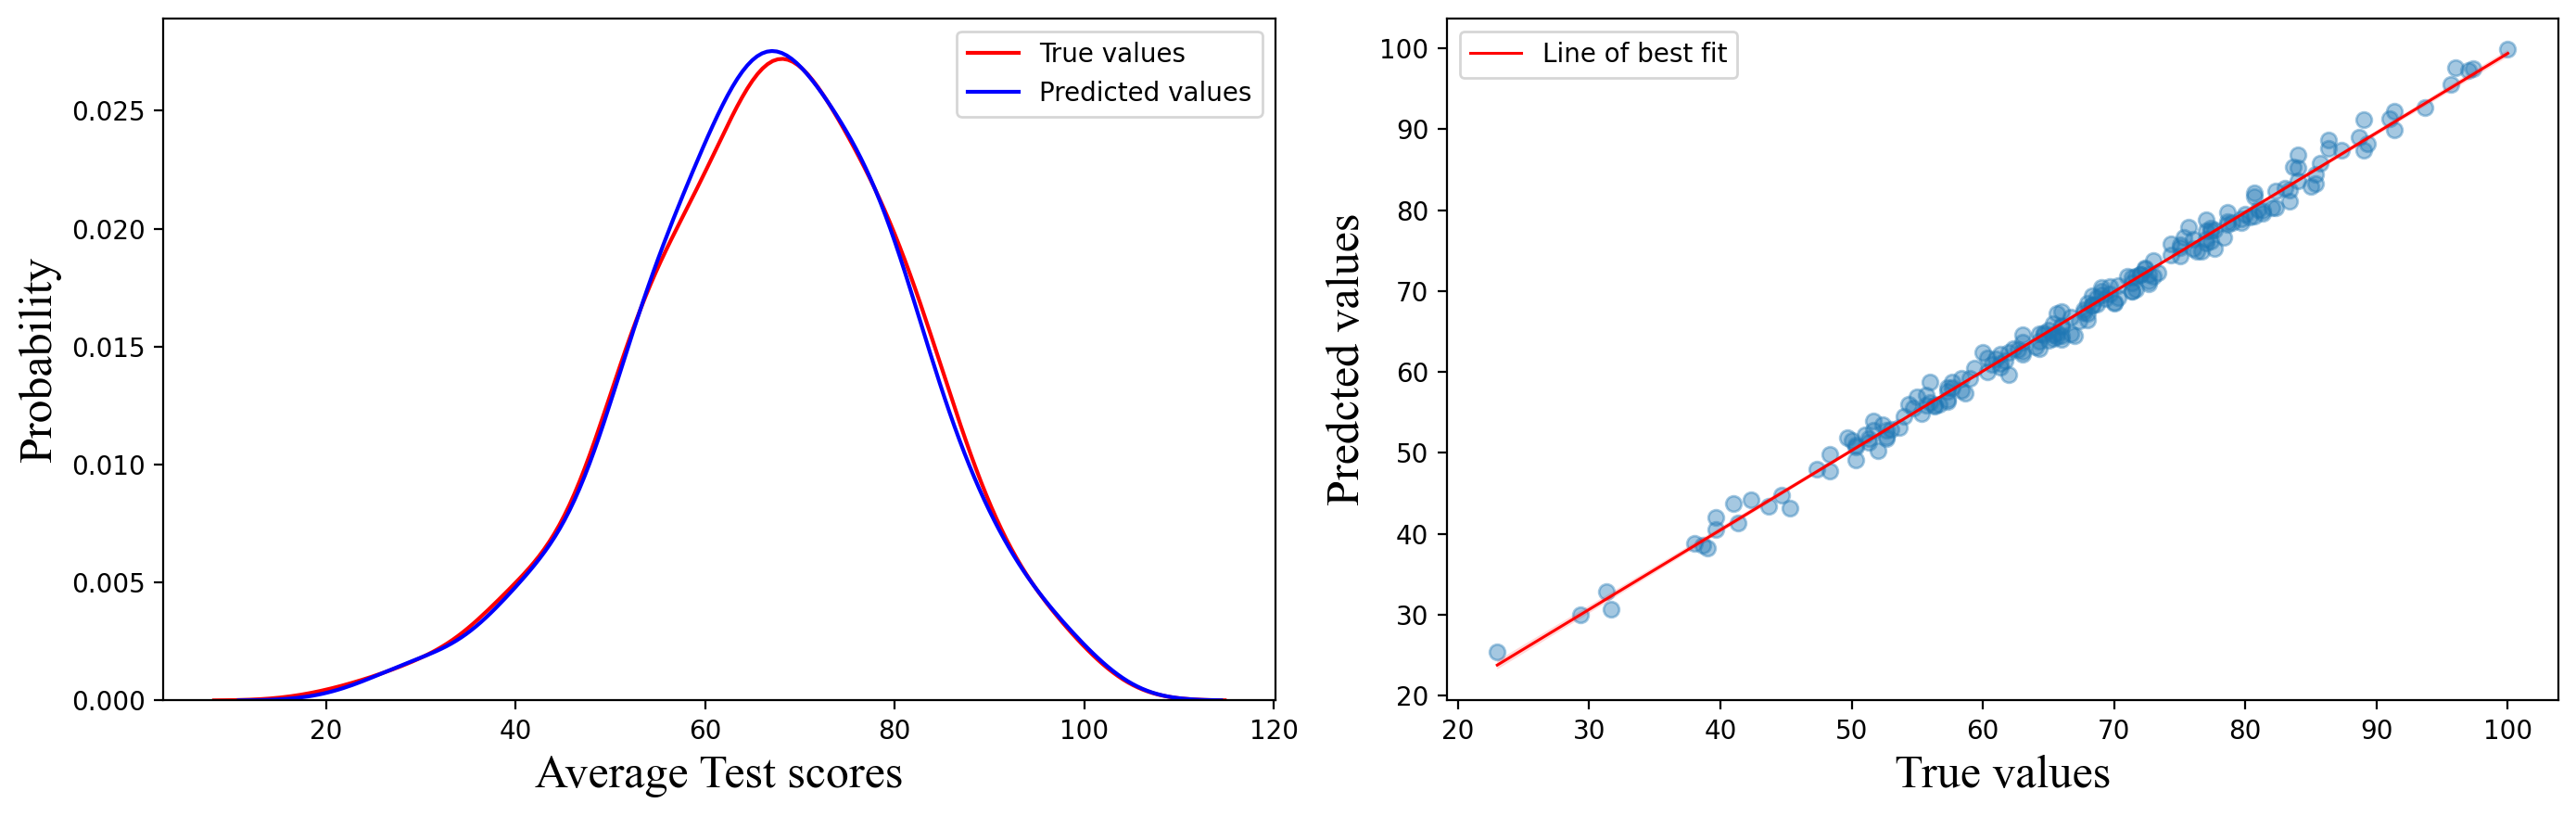

In [127]:
fig, ax = plt.subplots(nrows=1, ncols=2,
                     figsize=(14,4.5), dpi=200)

ax_kde, ax_reg = ax

# scatter plot
# ax_scatter.scatter(y_test, lr_predictions_test, alpha=0.5)
sns.kdeplot(y_test, ax=ax_kde, color="red", label="True values")
sns.kdeplot(lr_predictions_test, ax=ax_kde, color="blue", label="Predicted values")

ax_kde.legend()
ax_kde.set_xlabel("Average Test scores", text_axis)
ax_kde.set_ylabel("Probability", text_axis)



# regression plot

scatter_kws = dict(marker="o", alpha=0.4, )
line_kws = dict(color="red", linewidth=1.1, label="Line of best fit")

sns.regplot(x=y_test, y=lr_predictions_test, ax=ax_reg,
           scatter_kws=scatter_kws, line_kws=line_kws)
ax_reg.legend()
ax_reg.set_xlabel("True values", text_axis)
ax_reg.set_ylabel("Predcted values", text_axis)


fig.tight_layout();

In [128]:
# get and store prediction dataframe
data_lr_results = {
    "Actual Value":y_test,
    "Predicted Value":lr_predictions_test,
    "Difference":(y_test - lr_predictions_test)
}
result_lr = pd.DataFrame(data=data_lr_results)

result_lr

,Actual Value,Predicted Value,Difference
993,69.333333,69.035156,0.298177
859,77.333333,77.410156,-0.076823
298,45.333333,43.175781,2.157552
553,67.666667,67.648438,0.018229
672,74.333333,74.507812,-0.174479
...,...,...,...
679,61.333333,61.003906,0.329427
722,84.000000,83.585938,0.414062
215,80.666667,82.156250,-1.489583
653,69.666667,69.660156,0.006510


In [133]:
file_path_lr_predictions = Path(r"D:\ML Project\notebook\data_results")

result_lr.to_csv(file_path_results / "result_lr.csv", index=False)

---